In [0]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
df = pd.read_csv('../input/training/training.csv')
df.dropna(inplace=True)
df.shape

(2140, 31)

In [0]:
from joblib import Parallel, delayed

def format_img(x):
    return np.asarray([int(e) for e in x.split(' ')], dtype=np.uint8).reshape(96,96)

with Parallel(n_jobs=10, verbose=1, prefer='threads') as ex:
    x = ex(delayed(format_img)(e) for e in df.Image)
    
x = np.stack(x)[..., None]
x.shape

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    2.9s
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:    4.6s
[Parallel(n_jobs=10)]: Done 1230 tasks      | elapsed:    6.3s
[Parallel(n_jobs=10)]: Done 1780 tasks      | elapsed:    8.4s
[Parallel(n_jobs=10)]: Done 2140 out of 2140 | elapsed:    9.8s finished


(2140, 96, 96, 1)

In [0]:
y = df.iloc[:, :-1].values
y.shape

(2140, 30)

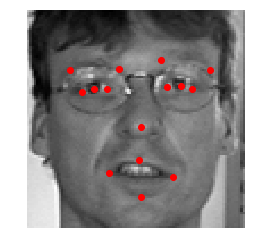

In [0]:
def show(x, y=None):
    plt.imshow(x[..., 0], 'gray')
    if y is not None:
        points = np.vstack(np.split(y, 15)).T
        plt.plot(points[0], points[1], 'o', color='red')
        
    plt.axis('off')

sample_idx = np.random.choice(len(x))    
show(x[sample_idx], y[sample_idx])

# Train validation split

In [0]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)
x_train.shape, x_val.shape

((1712, 96, 96, 1), (428, 96, 96, 1))

In [0]:
y_train.shape, y_val.shape

((1712, 30), (428, 30))

In [0]:
x_train_norm=x_train[:,:,:,:]
x_val_norm=x_val[:,:,:,:]
x_train_norm=x_train_norm.reshape([1712,96*96,1])
x_val_norm=x_val_norm.reshape([428,96*96,1])

mu=x_train_norm.mean()
sigma=x_train_norm.std()

x_train_norm=(x_train_norm - mu)/sigma
x_val_norm=(x_val_norm - mu)/sigma

x_train_norm.shape, x_val_norm.shape, x_train_norm.mean(), x_train_norm.std(), x_val_norm.mean(), x_val_norm.std()



((1712, 9216, 1),
 (428, 9216, 1),
 -9.338324506192905e-18,
 0.9999999999999999,
 -0.06512222683585148,
 0.9844637045228576)

In [0]:
x_train_norm=x_train_norm.reshape([1712,96,96,1])
x_val_norm=x_val_norm.reshape([428,96,96,1])

x_train_norm.shape, x_val_norm.shape

((1712, 96, 96, 1), (428, 96, 96, 1))

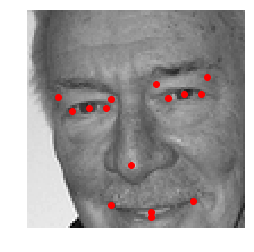

In [0]:
show(x_train_norm[15], y_train[15])

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, AvgPool2D, BatchNormalization, Dropout
from keras.optimizers import Adam
from keras import regularizers

model=Sequential([
    Conv2D(72,4,input_shape=(96,96,1),activation='relu',kernel_initializer='he_normal',kernel_regularizer=regularizers.l2(0.01)),
    AvgPool2D(pool_size=(2,2)),
    Conv2D(48,2,activation='relu',use_bias=False,kernel_initializer='he_normal' ,kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    Flatten(),
    Dropout(0.5),
    Dense(48,activation='relu', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01)),
    Dense(30, kernel_initializer='he_normal',kernel_regularizer=regularizers.l2(0.01))
])

model.compile(optimizer=Adam(0.01),loss='mse',metrics=['mae'])

Using TensorFlow backend.


In [0]:
model.summary(), model.input, model.output

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 93, 93, 72)        1224      
_________________________________________________________________
average_pooling2d_1 (Average (None, 46, 46, 72)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 48)        13824     
_________________________________________________________________
batch_normalization_1 (Batch (None, 45, 45, 48)        192       
_________________________________________________________________
flatten_1 (Flatten)          (None, 97200)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 97200)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 48)                4665648   
__________

(None,
 <tf.Tensor 'conv2d_1_input:0' shape=(?, 96, 96, 1) dtype=float32>,
 <tf.Tensor 'dense_2/BiasAdd:0' shape=(?, 30) dtype=float32>)

In [0]:
log=model.fit(x_train_norm, y_train, epochs=150, batch_size=256, validation_data=[x_val_norm,y_val])

Train on 1712 samples, validate on 428 samples
Epoch 1/150
1712/1712 [==============================] - 7s 4ms/step - loss: 4947.1383 - mean_absolute_error: 55.8505 - val_loss: 4230.6356 - val_mean_absolute_error: 50.7417
Epoch 2/150
1712/1712 [==============================] - 1s 348us/step - loss: 2584.1191 - mean_absolute_error: 45.5348 - val_loss: 3288.5933 - val_mean_absolute_error: 47.6502
Epoch 3/150
1712/1712 [==============================] - 1s 342us/step - loss: 2244.7472 - mean_absolute_error: 40.9299 - val_loss: 2393.5068 - val_mean_absolute_error: 41.8153
Epoch 4/150
1712/1712 [==============================] - 1s 348us/step - loss: 1674.3742 - mean_absolute_error: 33.2365 - val_loss: 1499.9005 - val_mean_absolute_error: 29.6676
Epoch 5/150
1712/1712 [==============================] - 1s 340us/step - loss: 891.4484 - mean_absolute_error: 21.8887 - val_loss: 1828.2213 - val_mean_absolute_error: 29.7699
Epoch 6/150
1712/1712 [==============================] - 1s 343us/step 

Epoch 48/150
1712/1712 [==============================] - 1s 342us/step - loss: 51.2676 - mean_absolute_error: 2.5390 - val_loss: 60.1773 - val_mean_absolute_error: 3.3427
Epoch 49/150
1712/1712 [==============================] - 1s 335us/step - loss: 50.4349 - mean_absolute_error: 2.5488 - val_loss: 54.3232 - val_mean_absolute_error: 2.9467
Epoch 50/150
1712/1712 [==============================] - 1s 326us/step - loss: 49.2281 - mean_absolute_error: 2.5048 - val_loss: 53.7328 - val_mean_absolute_error: 2.9834
Epoch 51/150
1712/1712 [==============================] - 1s 330us/step - loss: 48.0072 - mean_absolute_error: 2.4638 - val_loss: 54.2593 - val_mean_absolute_error: 3.1345
Epoch 52/150
1712/1712 [==============================] - 1s 326us/step - loss: 46.9994 - mean_absolute_error: 2.4371 - val_loss: 50.6293 - val_mean_absolute_error: 2.8426
Epoch 53/150
1712/1712 [==============================] - 1s 338us/step - loss: 45.8552 - mean_absolute_error: 2.3946 - val_loss: 49.3048 - 

1712/1712 [==============================] - 1s 330us/step - loss: 23.6692 - mean_absolute_error: 2.1194 - val_loss: 25.3816 - val_mean_absolute_error: 2.2679
Epoch 96/150
1712/1712 [==============================] - 1s 332us/step - loss: 23.6678 - mean_absolute_error: 2.1590 - val_loss: 23.4914 - val_mean_absolute_error: 2.0855
Epoch 97/150
1712/1712 [==============================] - 1s 331us/step - loss: 22.9948 - mean_absolute_error: 2.1019 - val_loss: 23.5775 - val_mean_absolute_error: 2.1385
Epoch 98/150
1712/1712 [==============================] - 1s 332us/step - loss: 22.5788 - mean_absolute_error: 2.0753 - val_loss: 22.8400 - val_mean_absolute_error: 2.0619
Epoch 99/150
1712/1712 [==============================] - 1s 330us/step - loss: 22.0348 - mean_absolute_error: 2.0303 - val_loss: 22.6586 - val_mean_absolute_error: 2.0586
Epoch 100/150
1712/1712 [==============================] - 1s 328us/step - loss: 21.7629 - mean_absolute_error: 2.0200 - val_loss: 22.5244 - val_mean_abs

1712/1712 [==============================] - 1s 331us/step - loss: 13.7903 - mean_absolute_error: 1.7588 - val_loss: 14.8970 - val_mean_absolute_error: 1.8970
Epoch 143/150
1712/1712 [==============================] - 1s 334us/step - loss: 13.7017 - mean_absolute_error: 1.7661 - val_loss: 15.5477 - val_mean_absolute_error: 2.0121
Epoch 144/150
1712/1712 [==============================] - 1s 331us/step - loss: 13.4055 - mean_absolute_error: 1.7316 - val_loss: 15.1177 - val_mean_absolute_error: 1.9690
Epoch 145/150
1712/1712 [==============================] - 1s 334us/step - loss: 13.3607 - mean_absolute_error: 1.7368 - val_loss: 13.8605 - val_mean_absolute_error: 1.7699
Epoch 146/150
1712/1712 [==============================] - 1s 335us/step - loss: 13.0845 - mean_absolute_error: 1.7088 - val_loss: 14.0727 - val_mean_absolute_error: 1.8168
Epoch 147/150
1712/1712 [==============================] - 1s 328us/step - loss: 12.9590 - mean_absolute_error: 1.7034 - val_loss: 13.8910 - val_mean

In [0]:
print(f'final MAE: {model.evaluate(x_val, y_val)[1]}')
print(f'final MAE: {model.evaluate((x_val-mu)/sigma, y_val)[1]}')
print(f'final MAE: {model.evaluate(x_val_norm, y_val)[1]}')

428/428 [==============================] - 0s 176us/step
MAE final: 713.2082428263726
428/428 [==============================] - 0s 154us/step
MAE final: 2.0694069383300353
428/428 [==============================] - 0s 157us/step
MAE final: 2.0694069383300353


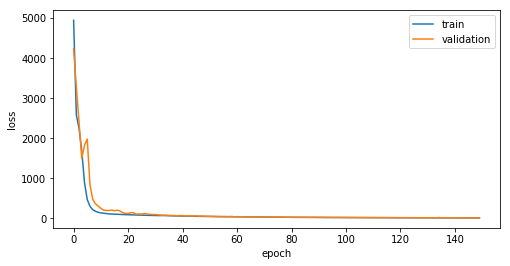

In [0]:
def show_results(*logs):
    trn_loss, val_loss, trn_acc, val_acc = [], [], [], []
    
    for log in logs:
        trn_loss += log.history['loss']
        val_loss += log.history['val_loss']
    
    fig, ax = plt.subplots(figsize=(8,4))
    ax.plot(trn_loss, label='train')
    ax.plot(val_loss, label='validation')
    ax.set_xlabel('epoch'); ax.set_ylabel('loss')
    ax.legend()
    
show_results(log)

In [0]:
def show_pred(x, y_real, y_pred):
    fig, axes = plt.subplots(1, 2, figsize=(10,5))
    for ax in axes:
        ax.imshow(x[0, ..., 0], 'gray')
        ax.axis('off')
        
    points_real = np.vstack(np.split(y_real[0], 15)).T
    points_pred = np.vstack(np.split(y_pred[0], 15)).T
    axes[0].plot(points_pred[0], points_pred[1], 'o', color='red')
    axes[0].set_title('Predictions', size=16)
    axes[1].plot(points_real[0], points_real[1], 'o', color='green')
    axes[1].plot(points_pred[0], points_pred[1], 'o', color='red', alpha=0.5)
    axes[1].set_title('Real', size=16)

In [0]:
prediction_val=model.predict(x_val_norm)
residue_val=np.abs(prediction_val - y_val)
mad_val=np.sum(residue_val, axis=1)/30

indices=mad_val.argsort()

(428,)

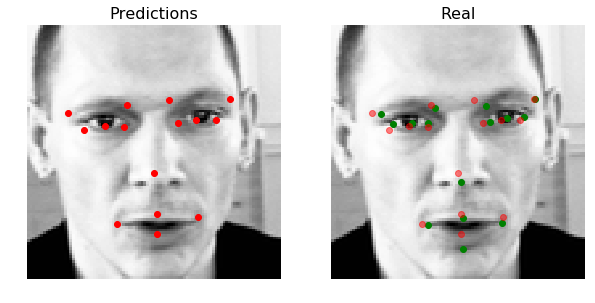

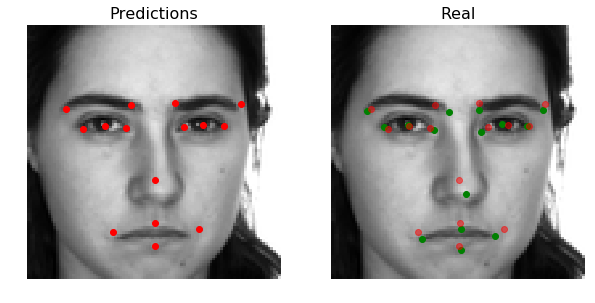

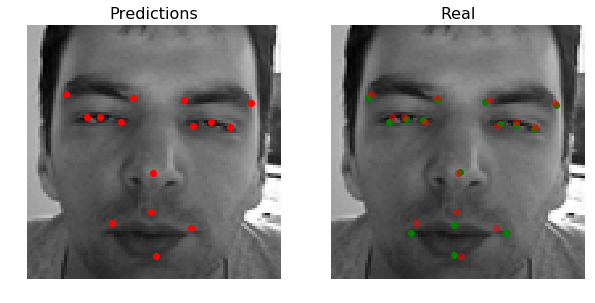

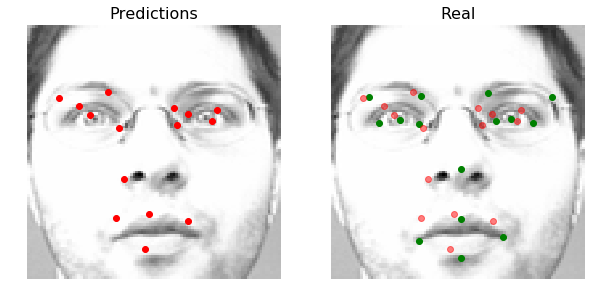

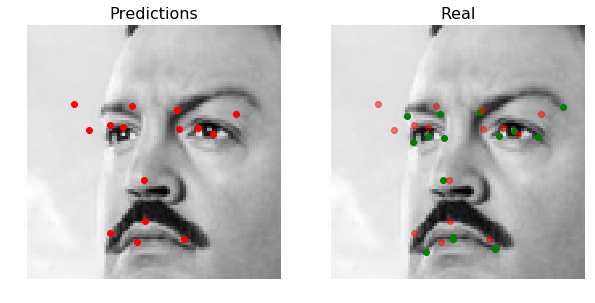

In [0]:
for _ in range(5):
    index = np.random.choice(x_val_norm.shape[0])
    sample_x = x_val_norm[index, None]
    sample_y = y_val[index, None]
    pred = model.predict(sample_x)
    show_pred(sample_x, sample_y, pred)

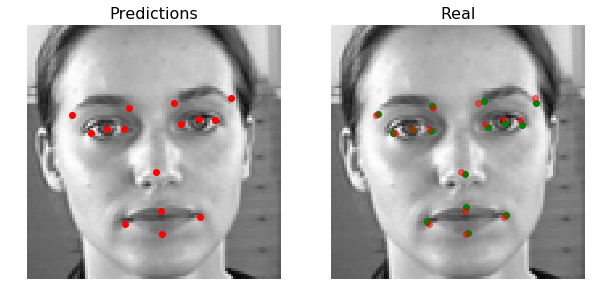

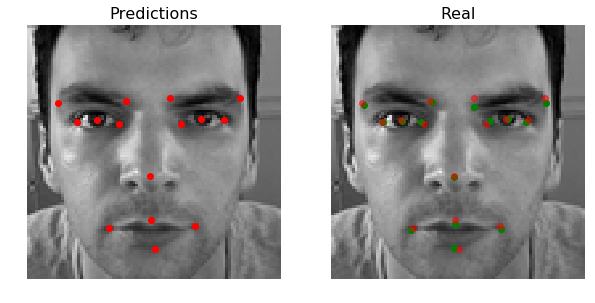

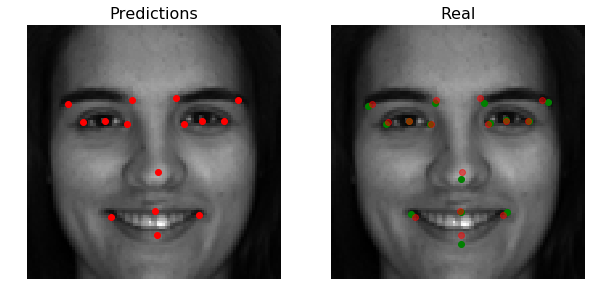

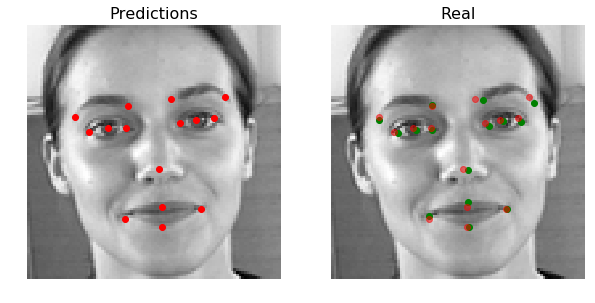

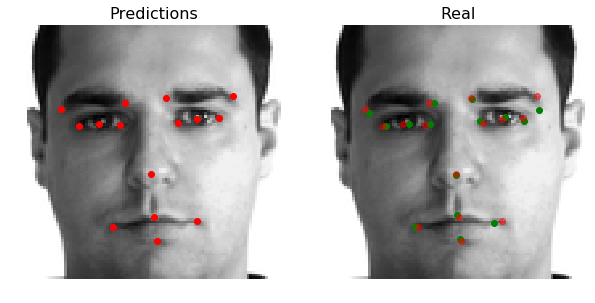

In [0]:
for i in range(5):
    sample_x = x_val_norm[indices[i], None]
    sample_y = y_val[indices[i], None]
    pred = model.predict(sample_x)
    show_pred(sample_x, sample_y, pred)

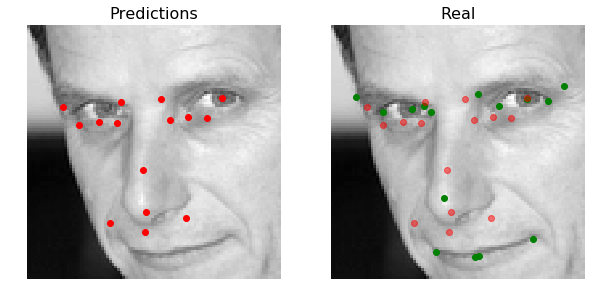

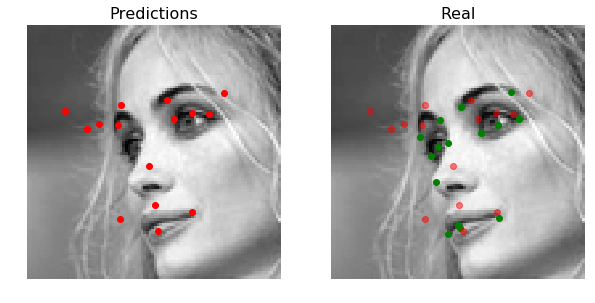

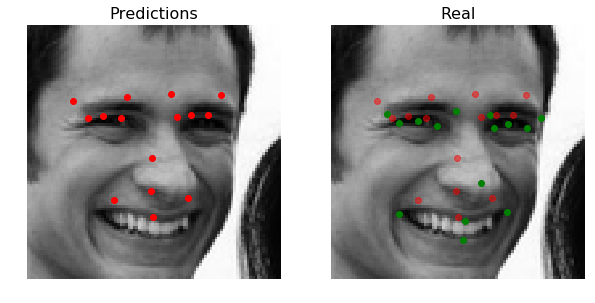

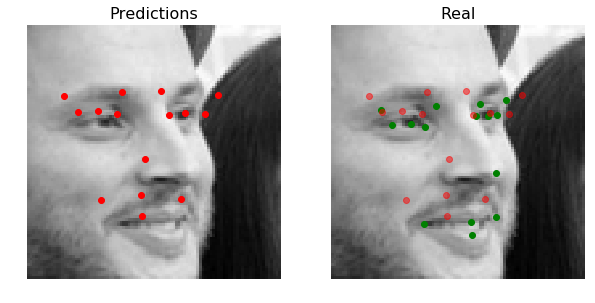

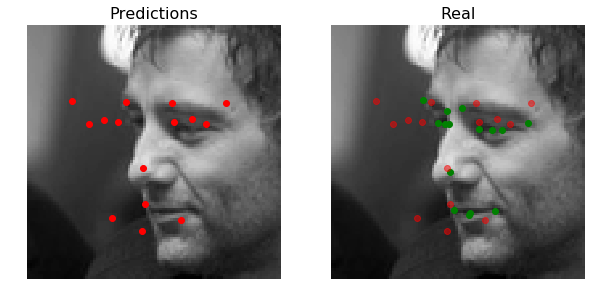

In [0]:
for i in range(-1,-6,-1):
    sample_x = x_val_norm[indices[i], None]
    sample_y = y_val[indices[i], None]
    pred = model.predict(sample_x)
    show_pred(sample_x, sample_y, pred)